In [14]:
%%html
<style>
table {float:left}
</style>

# Playground with the fashion-mnist

## Features explanation
Each column represent pixel gray scale from 0 to 255 (8 bit).

## Lables explanation
| Label | Description |
| --- | ---- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## Download the data

In [3]:
%%bash
rm -frd /data
kaggle datasets download -d zalando-research/fashionmnist -p data
unzip data/fashionmnist.zip -d data/
rm data/t*


Archive:  data/fashionmnist.zip
  inflating: data/t10k-images-idx3-ubyte  
  inflating: data/fashion-mnist_test.csv  
  inflating: data/train-labels-idx1-ubyte  
  inflating: data/train-images-idx3-ubyte  
  inflating: data/fashion-mnist_train.csv  
  inflating: data/t10k-labels-idx1-ubyte  


100%|██████████| 68.8M/68.8M [00:03<00:00, 18.9MB/s]


In [1]:
from pathlib import Path
from typing import Tuple, Union

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms, utils

# %matplotlib inline
%matplotlib notebook

### Set data split and batch size

In [2]:
rows_to_import = 5000 # how many rows to import (1 - 60000), if None use all data

train = 0.70
test = 0.15
cv = 1 - train - test

split = (train, test, cv)
assert cv > 0 and cv < 1, f"cross validation share has to be between 0 and 1 not {cv}"

batch_size = 32
num_workers = 64

### Dataset preparation

In [3]:
class FashionMnist(Dataset):
    
    @staticmethod
    def _get_csv_length(csv: Path) -> int:
        "Get rows count of a csv file"
        with open(csv) as f:
            return sum(1 for line in f)

    @staticmethod
    def _check_split(split: Tuple[int, int, int]) -> None:
        "Check if split elements are positive and sum to one"
        sum_ = 0
        for i, element in enumerate(split):
            assert element >= 0, f"Split element {i} is negative: {element}"            
            assert element <= 1, f"Split element {i} is greater than 1: {element}"
            sum_ += abs(element)
        assert sum_ == 1, f"Sum of a split elements is unequal to 1"
    
    def _read_csv(self, 
                  test: bool,
                  cv: bool,
                  rows_no: Union[None, int], 
                  split: Tuple[int, int, int]) -> pd.DataFrame:
        """
        Read csv file to get specific dataset (train, test or cv)
        :param test: True if it is a test set
        :param cv: True if it is a cross-validation set
        :param rows_no: number of rows to use (None == all rows)
        :param split: tuple with train, test, and cv shares, e.g. (0.8, 0.1, 0.1)
        :return: pd.DataFrame with rows and header

        """
        rows_in_csv = self._get_csv_length(self.csv_path)
        
        if rows_no is None:
            rows_no = rows_in_csv

        assert (rows_no >= 1) and (rows_no <= rows_in_csv), f"rows_no is exceeding 1 - {rows_in_csv} range: {rows_no}"
        assert not (test and cv), "Dataset cannot be a test and a cross-validation at the same moment"
        self._check_split(split)
        
        train_no = int(rows_no * split[0])
        test_no =  int(rows_no * split[1])
        cv_no =  int(rows_no * split[2])

        cv_boundary = train_no + test_no
        
        if test:
            df = pd.read_csv(self.csv_path, skiprows=range(1, train_no), nrows=test_no)
        elif cv:
            df = pd.read_csv(self.csv_path, skiprows=range(1, cv_boundary), nrows=cv_no)
        else:
            df = pd.read_csv(self.csv_path, nrows=train_no)
        
        return df        
    
    def __init__(self, 
                 transform=None, 
                 test: bool = False,
                 cv: bool = False,
                 rows_no: Union[None, int] = None, 
                 split: Tuple[int, int, int] = (1, 0, 0)):
        """
        Create Dataset containing the Fashon Mnist data.
        :param transform: transformations to perform on the dataset
        :param test: True if it is a test set
        :param cv: True if it is a cross-validation set
        :param rows_no: number of rows to use (None == all rows)
        :param split: tuple with train, test, and cv shares, e.g. (0.8, 0.1, 0.1)

        """
        self.csv_path = Path('data/fashion-mnist_train.csv')
        data = self._read_csv(test, cv, rows_no, split)
        self.data = data.to_numpy()
        self.transform = transform
        
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        image = self.data[index, 1:]
        label = self.data[index, 0]
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.data)

    def __add__(self, other):
        return ConcatDataset([self, other])




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        return {'image': torch.from_numpy(image).float(),
                'label': torch.tensor(label).long()}




In [4]:
transform = transform=transforms.Compose([ToTensor()])

train_dataset = FashionMnist(rows_no=rows_to_import, transform=transform, split=split)
test_dataset = FashionMnist(rows_no=rows_to_import, transform=transform, split=split, test=True)
cv_dataset = FashionMnist(rows_no=rows_to_import, transform=transform, split=split, cv=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,  shuffle=True, num_workers=num_workers)
cv_dataloader = torch.utils.data.DataLoader(cv_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

## Building the model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x


### Set the Optimizer and the Loss function

### Train Network

In [17]:
epoch_no = 10
train_stats_freq = 1  # calculate stats every x epoch
cv_stats_freq = 1  # calculate cv stats every x epoch

In [18]:
class Stats:
    @property
    def loss(self) -> Tuple[np.array, np.array]:
        "Get epochs and loss"
        return self.epochs, self.losses
    
    @property
    def accuracy(self) -> Tuple[np.array, np.array]:
        "Get epochs and accuracy"
        return self.epochs, self.accuracies

    
class TrainStats(Stats):
    def __init__(self, stats_freq: int):
        """
        Calculate and show stats related to the train data.
        :param stats_freq: print stats every stats_freq batch
        """
        self.stats_freq = stats_freq
        self.accuracies = np.array([], dtype=float)
        self.losses = np.array([], dtype=float)
        self.epochs = np.array([], dtype=int)
        
        
    def __call__(self, epoch: int, loss: float, accuracy: float, *args, **kwargs):
        if epoch % self.stats_freq == self.stats_freq - 1:
            self.accuracies = np.append(self.accuracies, accuracy)
            self.losses = np.append(self.losses, loss)
            self.epochs = np.append(self.epochs, epoch + 1)
    
    
class CVStats(Stats):
    def __init__(self, stats_freq: int, cv_dataloader):
        """
        Calculate and show stats related to the cross-validation data.
        :param stats_freq: print stats every stats_freq batch
        :param cv_dataloader: dataloader with the cv data
        """
        self.stats_freq = stats_freq
        self.accuracies = np.array([], dtype=float)
        self.losses = np.array([], dtype=float)
        self.epochs = np.array([], dtype=int)
        self.cv_dataloader = cv_dataloader
        
    def __call__(self, model):
        if epoch % self.stats_freq == self.stats_freq - 1:
            loss, accuracy = self._get_cv_loss_and_accuracy(model)
            self.accuracies = np.append(self.accuracies, accuracy)
            self.losses = np.append(self.losses, loss)
            self.epochs = np.append(self.epochs, epoch + 1)


    def _get_cv_loss_and_accuracy(self, model) -> Tuple[float, float]:
        "Compute CV loss on the whole CV dataset"
        with torch.no_grad():
            accumualted_loss = 0.0
            epoch_good_predicitions = 0

            for i, data in enumerate(cv_dataloader, 0):
                inputs, labels = data['image'], data['label']

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                batch_size = outputs.shape[0]
                accumualted_loss += loss.item() * batch_size
                max_index = outputs.max(dim = 1)[1]
                epoch_good_predicitions += int((max_index == labels).sum())
                
        accuracy = epoch_good_predicitions / (cv * rows_to_import) * 100
        mean_loss = accumualted_loss / (cv * rows_to_import)

        return mean_loss, accuracy

In [24]:
class PlotStats:
    def __init__(self):
        self.fig, self.axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
        self._configure_plots()

    def _configure_plots(self):
        self.axs[0].set_title('Loss')
        self.axs[0].set_yscale("log", nonposy='clip')
        self.axs[0].set_ylabel("Loss")
        self.axs[0].set_xlabel("Epoch")

        self.axs[1].set_title('Accuracy')
        self.axs[1].set_ylabel("Accuracy [%]")
        self.axs[1].set_ylim((-5, 105))

        self.axs[1].set_xlabel("Epoch")
        
    def __call__(self, train_stats, cv_stats):
        epoch = train_stats.loss[0][-1]
        self.fig.suptitle(f'Epoch {epoch}')
        self.axs[0].plot(*train_stats.loss, '-b', *cv_stats.loss, '-r')
        self.axs[1].plot(*train_stats.accuracy, '-b', *cv_stats.accuracy, '-r')
        
        self.fig.legend(labels=['Train', 'CV'], loc="center right",  borderaxespad=0.1)
        plt.subplots_adjust(right=0.92)
        self.fig.canvas.draw()
        display.clear_output(wait=True)
        display.display(plt.gcf())

        


Finished Training


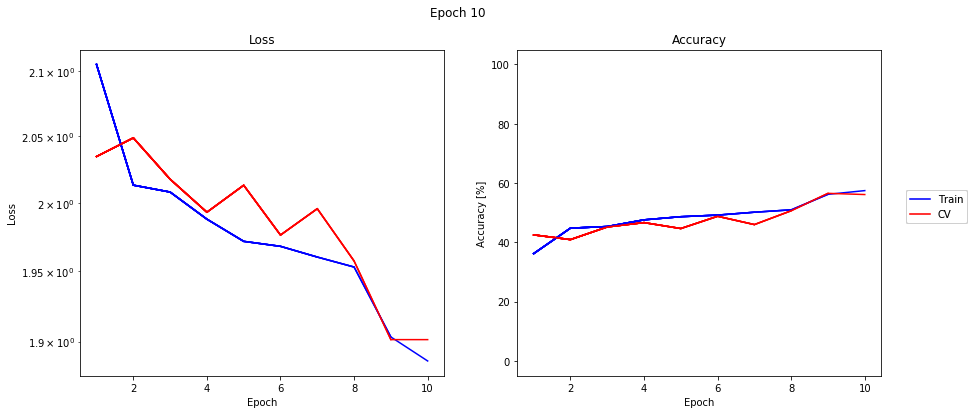

In [25]:
net = Net()
train_stats = TrainStats(train_stats_freq)
cv_stats = CVStats(cv_stats_freq, cv_dataloader)

plot_stats = PlotStats()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)


for epoch in range(epoch_no):  # loop over the dataset multiple times
    accumualted_loss = 0.0
    epoch_good_predicitions = 0
    
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data['image'], data['label']

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batch_size = outputs.shape[0]

        accumualted_loss += loss.item() * batch_size
        max_index = outputs.max(dim = 1)[1]
        epoch_good_predicitions += int((max_index == labels).sum())

    epoch_accuracy = epoch_good_predicitions / (train * rows_to_import) * 100
    mean_loss = accumualted_loss / (train * rows_to_import)
    train_stats(epoch, mean_loss, epoch_accuracy)
    cv_stats(net)
    
    plot_stats(train_stats, cv_stats)

    display.clear_output(wait=True)
print('Finished Training')